In [25]:


import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy import sparse
from datetime import datetime
from scipy.linalg import solve
from scipy.optimize import minimize



In [26]:
class Optimizer:
    def __init__(self):
        pass

    def optimize(self):
        raise NotImplementedError("Subclasses must implement the optimize method.")


In [27]:
test = pd.read_csv('../data/testing/sq_scores.csv')
test['location'] = test['location'].map({'home':1,'neutral':0,'away':-1})
test['sq_diff'] = test['team_sq_score'].copy() - test['opp_sq_score'].copy()

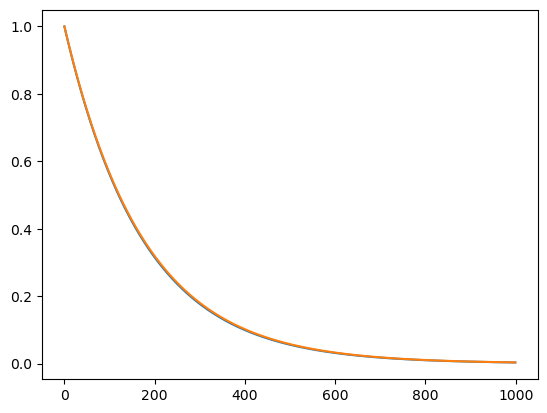

In [28]:
import matplotlib.pyplot as plt
halflife = 120
decay = np.exp(-np.log(2)/halflife)
x = np.arange(0, 1000)
decay2 = np.exp(-x/175)
plt.plot(x, decay ** (x))
plt.plot(x, decay2)

In [54]:
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression

In [55]:


class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='team_sq_score', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, init_points=10, n_iter=30, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_bayes_objective(offense_halflife, defense_halflife, meta_halflife, l2):
            # offense_halflife, defense_halflife, meta_halflife_bounds, l2 = params
            correlations = []
            # l2 = 1e-8
            
            offense_decay = np.exp(-np.log(2)/offense_halflife)
            defense_decay = np.exp(-np.log(2)/defense_halflife)
            meta_decay = np.exp(-np.log(2)/meta_halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Offense decay
                dwo = offense_decay ** days_ago
                dwo = dwo / np.sum(dwo)
                # Defense decay
                dwd = defense_decay ** days_ago
                dwd = dwd / np.sum(dwd)
                # Meta decay
                dwm = meta_decay ** days_ago
                dwm = dwm / np.sum(dwm)

                # Create separate weight matrices for offense and defense
                Wo = sparse.diags(dwo)
                Wd = sparse.diags(dwd)
                Wm = sparse.diags(dwm)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Split X_train into offense and defense parts
                X_train_offense = X_train[:, :self.num_protags]
                X_train_defense = X_train[:, self.num_protags:-1*len(self.meta_cols)]
                X_train_meta = X_train[:, -1*len(self.meta_cols):]

                # Apply the weight matrices to the corresponding parts of X_train
                X_train_weighted = sparse.hstack([Wo @ X_train_offense, Wd @ X_train_defense, Wm @ X_train_meta])

                # Quadratic term
                q = (X_train_weighted.T @ X_train_weighted).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train_weighted.T @ y_train

                if np.isnan(f).any():
                    print("Shit, something wrong")
                    return -1000

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings
                
                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                ratings_df = pd.DataFrame({
                    'off_rating': b[:self.num_protags],
                    'def_rating': b[self.num_protags:-1*len(self.meta_cols)]
                }, index=self.protags)
                test_data = test_data.join(ratings_df, on=self.protag_col)

                # Calculate the predicted scores
                linear_model = LinearRegression()
                linear_model.fit(test_data[['off_rating', 'def_rating', 'location']], test_data[self.stat_col])
                test_data['pred_score'] = linear_model.predict(test_data[['off_rating', 'def_rating', 'location']])
                test_data['mse'] = (test_data[self.stat_col] - test_data['pred_score']) ** 2
                mse = test_data['mse'].mean()

            return -mse  
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        pbounds = {'offense_halflife': offense_halflife_bounds, 'defense_halflife': defense_halflife_bounds, 'meta_halflife':meta_halflife_bounds, 'l2': l2_bounds}
        print(pbounds)
        # Initialize the Bayesian Optimization object
        optimizer = BayesianOptimization(f=time_bayes_objective, pbounds=pbounds, random_state=17)

        # Perform the optimization
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Get the best parameters and correlation
        best_params = optimizer.max['params']
        best_off_halflife = best_params['offense_halflife']
        best_def_halflife = best_params['defense_halflife']
        best_meta_halflife = best_params['meta_halflife']
        best_l2 = best_params['l2']
        best_correlation = -optimizer.max['target']

        return best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        optimal_off_halflifes = []
        optimal_def_halflifes = []
        optimal_meta_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation = self.run_time_opt_scipy(13, 32, num_test_dates, num_future_days, max_lookback, offense_halflife_bounds, defense_halflife_bounds, meta_halflife_bounds, l2_bounds)
            optimal_off_halflifes.append(best_off_halflife)
            optimal_def_halflifes.append(best_def_halflife)
            optimal_meta_halflifes.append(best_meta_halflife)
            optimal_l2s.append(best_l2)
            best_correlations.append(best_correlation)
        return optimal_off_halflifes, optimal_def_halflifes, optimal_meta_halflifes, optimal_l2s, best_correlations

MO = MasseyOptimizer('time')
MO.load_data(test)
off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs = MO.run_full_time_opt(num_samples=25, num_test_dates=30, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1))


  0%|          | 0/25 [00:00<?, ?it/s]

{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -85.97    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -89.85    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -87.62    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -91.1     | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -88.63    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -90.56    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -86.06    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -89.76    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -87.91    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 10        | -89.57    | 557.6     | 0.1185    | 411.5     | 716.0     |
| 

  4%|▍         | 1/25 [00:28<11:21, 28.40s/it]

| 45        | -85.93    | 382.8     | 0.2127    | 345.5     | 128.5     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -105.3    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -99.84    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -105.8    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -100.4    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -99.16    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -100.3    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -104.6    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -99.6     | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -99.33    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

  8%|▊         | 2/25 [00:58<11:15, 29.36s/it]

| 45        | -99.0     | 555.6     | 0.627     | 783.2     | 218.8     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -86.4     | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -90.98    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -89.74    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -92.58    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -89.26    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -92.13    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -88.66    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -91.12    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -90.13    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 12%|█▏        | 3/25 [01:27<10:39, 29.07s/it]

| 45        | -85.96    | 610.3     | 0.5112    | 705.4     | 109.3     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -96.73    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -92.04    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -97.89    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -92.31    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -91.55    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -92.61    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -97.44    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -92.02    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.75    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 16%|█▌        | 4/25 [01:58<10:25, 29.78s/it]

| 45        | -92.08    | 723.6     | 0.6807    | 796.1     | 517.6     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.99    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -97.81    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -94.23    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -99.32    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -95.87    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -99.4     | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.83    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -97.75    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -92.33    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 20%|██        | 5/25 [02:25<09:41, 29.05s/it]

| 45        | -89.26    | 496.3     | 0.1929    | 176.3     | 91.36     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -101.1    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -94.64    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -101.3    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -94.9     | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.59    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -95.13    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -101.3    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -94.48    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -96.48    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 24%|██▍       | 6/25 [02:57<09:28, 29.91s/it]

| 45        | -93.86    | 740.1     | 1e-08     | 323.4     | 386.2     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -81.81    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -84.93    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -83.35    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -85.79    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -84.43    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -86.12    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -81.6     | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -84.43    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -81.9     | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 28%|██▊       | 7/25 [03:25<08:49, 29.41s/it]

| 45        | -82.56    | 451.9     | 0.9877    | 298.3     | 117.8     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.61    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -96.56    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -93.53    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -97.96    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.93    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -97.98    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.86    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -96.4     | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.82    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 32%|███▏      | 8/25 [03:55<08:21, 29.53s/it]

| 45        | -89.54    | 278.3     | 0.3074    | 732.5     | 79.34     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -95.78    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -92.21    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -96.98    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -92.5     | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -91.61    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -92.9     | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -97.11    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -92.27    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.86    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 36%|███▌      | 9/25 [04:24<07:48, 29.26s/it]

| 45        | -90.65    | 736.9     | 1e-08     | 800.0     | 479.3     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -81.08    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -84.49    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -82.84    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -85.34    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -83.96    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -85.64    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -81.14    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -84.0     | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -81.72    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 40%|████      | 10/25 [04:52<07:15, 29.06s/it]

| 45        | -80.55    | 557.8     | 0.3724    | 675.5     | 51.78     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -91.71    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -96.31    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -93.57    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -97.56    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.9     | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -97.26    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -90.82    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -96.12    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -93.0     | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 44%|████▍     | 11/25 [05:22<06:48, 29.18s/it]

| 45        | -90.58    | 294.1     | 0.418     | 287.3     | 83.54     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.76    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -98.51    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -92.17    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -99.51    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -96.57    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -100.1    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.91    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -98.45    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.74    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 48%|████▊     | 12/25 [05:52<06:24, 29.57s/it]

| 45        | -90.24    | 590.1     | 1e-08     | 617.1     | 116.9     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.89    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -95.67    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -94.05    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -97.04    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.33    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -96.98    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.35    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -95.27    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -90.95    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 52%|█████▏    | 13/25 [06:22<05:55, 29.59s/it]

| 45        | -89.52    | 319.7     | 0.1969    | 289.2     | 88.17     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -79.22    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -80.17    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -78.12    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -80.63    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -79.77    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -80.31    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -80.2     | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -79.69    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -79.52    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 56%|█████▌    | 14/25 [06:52<05:28, 29.89s/it]

| 45        | -77.5     | 99.44     | 0.3652    | 719.4     | 59.88     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -89.74    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -96.37    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -92.41    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -97.77    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.24    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -98.13    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -88.53    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -96.51    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -90.35    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 60%|██████    | 15/25 [07:22<04:58, 29.88s/it]

| 45        | -96.48    | 723.6     | 0.6807    | 796.1     | 517.6     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -85.91    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -87.47    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -85.79    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -87.81    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -86.57    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -88.52    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -86.6     | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -87.79    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -86.16    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 64%|██████▍   | 16/25 [07:51<04:25, 29.48s/it]

| 45        | -87.52    | 723.6     | 0.6807    | 796.1     | 517.6     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -86.51    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -89.33    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -87.64    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -90.06    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -88.48    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -90.16    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -86.77    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -89.32    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -87.53    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 68%|██████▊   | 17/25 [08:21<03:56, 29.55s/it]

| 45        | -89.41    | 723.6     | 0.6807    | 796.1     | 517.6     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.16    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -96.15    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -93.02    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -97.56    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -94.51    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -97.53    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.46    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -95.98    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.41    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 72%|███████▏  | 18/25 [08:49<03:24, 29.26s/it]

| 45        | -89.52    | 293.3     | 0.3083    | 253.3     | 102.9     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -69.42    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -75.15    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -71.63    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -76.41    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -73.4     | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -76.22    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -70.56    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -75.25    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -72.84    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 76%|███████▌  | 19/25 [09:19<02:55, 29.30s/it]

| 45        | -68.71    | 277.8     | 0.2723    | 284.1     | 86.92     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -83.32    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -87.92    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -84.55    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -89.38    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -86.41    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -88.63    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -83.5     | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -87.73    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -85.03    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 80%|████████  | 20/25 [09:49<02:27, 29.55s/it]

| 45        | -82.35    | 266.6     | 0.2875    | 213.8     | 81.54     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -90.62    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -97.67    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -92.62    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -98.83    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -95.72    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -99.26    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -89.59    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -97.57    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -91.39    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 84%|████████▍ | 21/25 [10:20<02:00, 30.13s/it]

| 45        | -89.84    | 489.2     | 0.5222    | 458.3     | 76.93     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -79.6     | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -80.34    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -80.74    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -81.01    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -80.13    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -80.51    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -79.9     | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -80.05    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -80.46    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 88%|████████▊ | 22/25 [10:46<01:26, 28.80s/it]

| 45        | -80.36    | 723.6     | 0.6807    | 796.1     | 517.6     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -81.58    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -85.02    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -81.77    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -85.76    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -83.6     | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -86.08    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -82.04    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -85.21    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -82.19    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 92%|█████████▏| 23/25 [11:18<00:59, 29.72s/it]

| 45        | -81.93    | 378.3     | 1e-08     | 130.9     | 178.5     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -80.04    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -81.78    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -78.91    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -82.29    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -81.42    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -81.62    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -78.46    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -81.24    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -79.91    | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

 96%|█████████▌| 24/25 [11:47<00:29, 29.57s/it]

| 45        | -79.5     | 52.04     | 0.6689    | 779.7     | 88.03     |
{'offense_halflife': (50, 800), 'defense_halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | defens... |    l2     | meta_h... | offens... |
-------------------------------------------------------------------------
| 1         | -87.78    | 271.0     | 0.5306    | 234.1     | 100.9     |
| 2         | -91.79    | 640.2     | 0.6563    | 546.3     | 481.7     |
| 3         | -89.44    | 79.3      | 0.3578    | 762.0     | 95.03     |
| 4         | -93.02    | 698.0     | 0.8773    | 135.8     | 539.3     |
| 5         | -90.51    | 463.8     | 0.5975    | 438.5     | 262.2     |
| 6         | -92.69    | 273.3     | 0.5615    | 377.2     | 641.5     |
| 7         | -86.72    | 363.9     | 0.1439    | 205.6     | 91.43     |
| 8         | -91.55    | 588.5     | 0.2923    | 239.1     | 673.5     |
| 9         | -88.6     | 476.0     | 0.08234   | 481.5     | 169.2     |
| 

100%|██████████| 25/25 [12:18<00:00, 29.53s/it]

| 45        | -88.51    | 410.7     | 0.8119    | 245.0     | 83.25     |


In [56]:
off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs

([83.56163381879595,
  225.9960560835481,
  109.29241760705779,
  332.7152067347931,
  58.932677911659724,
  386.17029871384835,
  134.48919343675718,
  54.490296092083874,
  305.10716395246567,
  93.96502586112683,
  73.16837905960467,
  62.1613911865939,
  60.03843971998231,
  50.04917964866829,
  65.05537330470503,
  85.87179415115466,
  81.2858592279815,
  70.14808789041535,
  55.518314512135,
  71.37270654653875,
  73.88074820881872,
  52.20529146693021,
  115.99530486877656,
  91.43101266186783,
  50.30143902992544],
 [376.46279571533523,
  588.686811841095,
  610.2861327062105,
  681.5327759386106,
  271.2995760229007,
  740.0955428537465,
  389.2450888402862,
  465.5865228298951,
  645.4034287839422,
  615.6727252195888,
  274.6761276234264,
  514.9770761008486,
  320.64377708768836,
  76.59024398924498,
  387.8379094445319,
  632.1082826745063,
  785.36916650189,
  337.3543379257496,
  255.79761258969845,
  284.04912851297354,
  533.7195464452547,
  657.966446377666,
  404.470

In [65]:
np.median(off_halflifes), np.median(def_halflifes), np.mean(optimal_meta_halflife), np.mean(l2s), np.median(corrs)

(73.88074820881872,
 404.47097227847684,
 437.71088526903407,
 0.18075404766133624,
 85.96065998498014)

In [63]:
np.std(off_halflifes), np.std(def_halflifes), np.std(optimal_meta_halflife), np.std(l2s), np.std(corrs)

(92.10691318499515,
 176.21541259172625,
 203.1543083267181,
 0.1613359224359658,
 6.280611567208136)

In [69]:

class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='team_sq_score', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, init_points=10, n_iter=30, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_bayes_objective(halflife, meta_halflife, l2):
            # offense_halflife, defense_halflife, meta_halflife_bounds, l2 = params
            correlations = []
            # l2 = 1e-8
            
            decay = np.exp(-np.log(2)/halflife)
            meta_decay = np.exp(-np.log(2)/meta_halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Offense decay
                dw = decay ** days_ago
                dw = dw / np.sum(dw)

                # Meta decay
                dwm = meta_decay ** days_ago
                dwm = dwm / np.sum(dwm)

                # Create separate weight matrices for offense and defense
                W = sparse.diags(dw)
                Wm = sparse.diags(dwm)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Split X_train into offense and defense parts
                X_train_teams = X_train[:, :-1*len(self.meta_cols)]
                X_train_meta = X_train[:, -1*len(self.meta_cols):]

                # Apply the weight matrices to the corresponding parts of X_train
                X_train_weighted = sparse.hstack([W @ X_train_teams, Wm @ X_train_meta])

                # Quadratic term
                q = (X_train_weighted.T @ X_train_weighted).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train_weighted.T @ y_train

                if np.isnan(f).any():
                    print("Shit, something wrong")
                    return -1000

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings
                
                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                ratings_df = pd.DataFrame({
                    'off_rating': b[:self.num_protags],
                    'def_rating': b[self.num_protags:-1*len(self.meta_cols)]
                }, index=self.protags)
                test_data = test_data.join(ratings_df, on=self.protag_col)

                # Calculate the predicted scores
                linear_model = LinearRegression()
                linear_model.fit(test_data[['off_rating', 'def_rating', 'location']], test_data[self.stat_col])
                test_data['pred_score'] = linear_model.predict(test_data[['off_rating', 'def_rating', 'location']])
                test_data['mse'] = (test_data[self.stat_col] - test_data['pred_score']) ** 2
                mse = test_data['mse'].mean()

            return -mse  
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        pbounds = {'halflife': halflife_bounds,'meta_halflife':meta_halflife_bounds, 'l2': l2_bounds}
        # Initialize the Bayesian Optimization object
        optimizer = BayesianOptimization(f=time_bayes_objective, pbounds=pbounds, random_state=17)

        # Perform the optimization
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Get the best parameters and correlation
        best_params = optimizer.max['params']
        best_halflife = best_params['halflife']
        best_meta_halflife = best_params['meta_halflife']
        best_l2 = best_params['l2']
        best_correlation = -optimizer.max['target']

        return best_halflife, best_meta_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        optimal_halflifes = []
        optimal_meta_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            best_halflife, best_meta_halflife, best_l2, best_correlation = self.run_time_opt_scipy(13, 32, num_test_dates, num_future_days, max_lookback, halflife_bounds, meta_halflife_bounds, l2_bounds)
            optimal_halflifes.append(best_halflife)
            optimal_meta_halflifes.append(best_meta_halflife)
            optimal_l2s.append(best_l2)
            best_correlations.append(best_correlation)
        return optimal_halflifes, optimal_meta_halflifes, optimal_l2s, best_correlations

MO = MasseyOptimizer('time')
MO.load_data(test)
halflifes, meta_halflife, opt_l2s, mses = MO.run_full_time_opt(num_samples=25, num_test_dates=30, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1))



  0%|          | 0/25 [00:00<?, ?it/s]

{'halflife': (50, 800), 'meta_halflife': (100, 800), 'l2': (1e-08, 1)}
|   iter    |  target   | halflife  |    l2     | meta_h... |
-------------------------------------------------------------
| 1         | -80.75    | 271.0     | 0.5306    | 234.1     |
| 2         | -78.73    | 100.9     | 0.787     | 559.4     |
| 3         | -82.04    | 528.1     | 0.5756    | 127.3     |
| 4         | -81.64    | 318.4     | 0.9457    | 142.0     |
| 5         | -82.72    | 698.0     | 0.8773    | 135.8     |
| 6         | -81.76    | 539.3     | 0.5518    | 518.3     |
| 7         | -81.21    | 412.6     | 0.283     | 308.4     |
| 8         | -81.44    | 471.1     | 0.396     | 652.1     |
| 9         | -81.06    | 363.9     | 0.1439    | 205.6     |
| 10        | -78.56    | 91.43     | 0.718     | 304.6     |
| 11        | -80.23    | 199.1     | 0.8314    | 497.6     |
| 12        | -78.68    | 111.8     | 0.545     | 211.3     |
| 13        | -81.33    | 557.6     | 0.1185    | 411.5     |

  0%|          | 0/25 [00:29<?, ?it/s]

| 45        | -81.17    | 397.7     | 0.2808    | 798.1     |


NameError: name 'best_halflife' is not defined

In [ ]:

np.median(halflifes), np.median(meta_halflife), np.mean(opt_l2s),np.median(mses)

In [ ]:
(73.88074820881872,
 404.47097227847684,
 437.71088526903407,
 0.18075404766133624,
 85.96065998498014)

In [19]:


class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='sq_diff', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_scipy_objective(params):
            halflife, l2 = params
            correlations = []
            # l2 = 1e-8
            
            decay = np.exp(-np.log(2)/halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Decay weights
                dw = decay ** days_ago
                dw = dw / np.sum(dw)
                W = sparse.diags(dw)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Quadratic term
                q = (X_train.T @ W @ X_train).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train.T @ W @ y_train

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings

                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                # Quadratic term for test data
                test_q = (X_test.T @ X_test).toarray()
                test_q += l2 * np.eye(test_q.shape[0]) * np.trace(test_q) / test_q.shape[0]

                # Linear term for test data
                test_f = X_test.T @ y_test

                # Solution for test data
                test_b = solve(test_q, test_f, assume_a='pos')

                test_o_ratings[i] = test_b[0:self.num_protags]
                test_d_ratings[i] = test_b[self.num_protags:-1*len(self.meta_cols)]

                # Calculate correlation
                offense_correlation = np.corrcoef(massey_o_ratings[i], test_o_ratings[i])[0, 1]
                defense_correlation = np.corrcoef(massey_d_ratings[i], test_d_ratings[i])[0, 1]
                correlations.append(offense_correlation)
                correlations.append(defense_correlation)

            avg_correlation = np.mean(correlations)
            return -avg_correlation  # Minimize the negative of the average correlation
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        # Define the bounds for decay factor and L2 regularization
        bounds = [halflife_bounds, l2_bounds]

        # Perform the optimization
        result = minimize(time_scipy_objective, x0=[120, 1e-8], bounds=bounds)

        best_halflife, best_l2 = result.x
        best_correlation = -result.fun

        return best_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1)):

        optimal_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            halflife, l2, correlation = self.run_time_opt_scipy(num_test_dates, num_future_days, max_lookback, halflife_bounds, l2_bounds)
            optimal_halflifes.append(halflife)
            optimal_l2s.append(l2)
            best_correlations.append(correlation)
        return optimal_halflifes, optimal_l2s, best_correlations

MO = MasseyOptimizer('time')
MO.load_data(test)
halflifes, l2s, corrs = MO.run_full_time_opt(num_samples=25, num_test_dates=25, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1))


100%|██████████| 25/25 [23:26<00:00, 56.26s/it]


In [20]:
np.median(corrs)

0.6676111721648849

In [21]:
np.std(corrs)

0.044042715309061384

In [22]:
np.median(halflifes)


92.23985697579771

In [24]:
halflifes

[105.57193833059459,
 96.3410449944243,
 86.14671780182705,
 16.42583170971897,
 91.6117921541929,
 89.7567674650214,
 119.99968000107165,
 81.28030192688627,
 93.41436027475089,
 119.9920154854931,
 119.99797979854158,
 89.30346448249918,
 92.23985697579771,
 120.00409454462151,
 89.75819238764045,
 91.15336032186006,
 96.8520044060696,
 119.99810319134951,
 92.60876654549917,
 75.87486206203891,
 79.53062624455218,
 87.87488774423323,
 97.94089883070704,
 95.77691915330247,
 79.99390742911974]

In [23]:
np.std(halflifes)

20.609630074443366

(array([ 2.,  1.,  1.,  2.,  9., 10., 16., 13., 28., 52., 48., 61., 79.,
        75., 91., 73., 87., 76., 69., 50., 50., 27., 26., 19., 12.,  7.,
         9.,  3.,  1.,  3.]),
 array([ 45.75134609,  49.18600053,  52.62065497,  56.05530941,
         59.48996385,  62.92461829,  66.35927273,  69.79392717,
         73.22858161,  76.66323606,  80.0978905 ,  83.53254494,
         86.96719938,  90.40185382,  93.83650826,  97.2711627 ,
        100.70581714, 104.14047158, 107.57512602, 111.00978046,
        114.4444349 , 117.87908934, 121.31374378, 124.74839822,
        128.18305266, 131.6177071 , 135.05236154, 138.48701598,
        141.92167042, 145.35632486, 148.7909793 ]),
 <BarContainer object of 30 artists>)

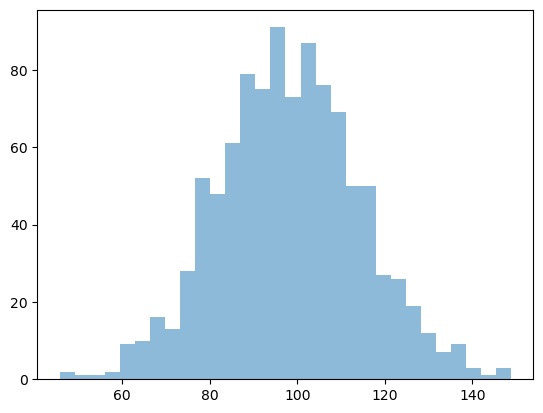

In [16]:
import matplotlib.pyplot as plt

dist = np.random.normal(np.mean(halflifes), np.std(halflifes), 1000)
plt.hist(dist, bins=30, alpha=0.5, label='Halflife')

In [12]:
np.median(l2s)

0.023284211858924424

In [243]:
MO.run_time_opt_scipy()

(10, 1000) (1e-09, 10.0)
120.0 1e-08
120.00000001 1e-08
120.0 2e-08
119.99992987806037 10.0
119.99992988806036 10.0
119.99992987806037 9.99999999
119.99997662875995 3.3329426171596155
119.99997663875995 3.3329426171596155
119.99997662875995 3.3329426271596154
119.99999221968864 1.109540248475384
119.99999222968863 1.109540248475384
119.99999221968864 1.109540258475384
119.99998492739546 1.1085146783179702
119.99998493739545 1.1085146783179702
119.99998492739546 1.1085146883179702
119.99995575822275 1.1044123976883151
119.99995576822275 1.1044123976883151
119.99995575822275 1.104412407688315
119.99983908153193 1.0880032751696946
119.99983909153192 1.0880032751696946
119.99983908153193 1.0880032851696946
119.99937237476864 1.0223667850952127
119.99937238476863 1.0223667850952127
119.99937237476864 1.0223667950952127
119.99750554771548 0.7598208247972851
119.99750555771547 0.7598208247972851
119.99750554771548 0.7598208347972851
119.99210285910503 1.000000082740371e-09
119.99210286910503 

(73.47040255911598, 0.04358970749781252, 0.6879707722143393)

In [211]:
t = pd.read_csv('test.csv')
t.sort_values(by=['test_o'], ascending=False).head(50)
t.corr()
t.sort_values(by=['massey_o'], ascending=False).head(50)

,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score,sq_diff
287,19784006508861,2024,ncaam,2024-03-02,1,Kentucky,Arkansas,111,102,92.4,87.7,NaN,NaN,4.7
627,19780088611471,2024,ncaam,2024-02-27,-1,Kentucky,Mississippi St.,91,89,78.2,76.8,NaN,NaN,1.4
952,19777001708861,2024,ncaam,2024-02-24,1,Kentucky,Alabama,117,95,85.7,83.7,NaN,NaN,2.0
1213,19774088610041,2024,ncaam,2024-02-21,-1,Kentucky,LSU,74,75,73.8,69.2,NaN,NaN,4.6
1567,19770009308861,2024,ncaam,2024-02-17,-1,Kentucky,Auburn,70,59,69.9,77.2,70.2,80.3,-7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105681,16397088611751,2015,ncaam,2014-11-23,1,Kentucky,Montana St.,86,28,104.3,52.3,102.6,59.6,52.0
105973,16395017808861,2015,ncaam,2014-11-21,1,Kentucky,Boston University,89,65,91.5,65.9,88.1,70.3,25.6
106216,16392087008861,2015,ncaam,2014-11-18,0,Kentucky,Kansas,72,40,76.5,69.6,77.3,73.1,6.9
106382,16390021508861,2015,ncaam,2014-11-16,1,Kentucky,Buffalo,71,52,82.7,50.6,83.4,56.0,32.1


In [235]:
MO.data.loc[MO.data['team'] == 'Kentucky']

,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score,sq_diff,protag_idx,antag_idx
215,16388071608861,2015,ncaam,2014-11-14,1,Kentucky,Grand Canyon,85,45,96.6,49.3,93.3,55.1,47.3,215,215
309,16390021508861,2015,ncaam,2014-11-16,1,Kentucky,Buffalo,71,52,82.7,50.6,83.4,56.0,32.1,215,141
504,16392087008861,2015,ncaam,2014-11-18,0,Kentucky,Kansas,72,40,76.5,69.6,77.3,73.1,6.9,215,130
736,16395017808861,2015,ncaam,2014-11-21,1,Kentucky,Boston University,89,65,91.5,65.9,88.1,70.3,25.6,215,270
1018,16397088611751,2015,ncaam,2014-11-23,1,Kentucky,Montana St.,86,28,104.3,52.3,102.6,59.6,52.0,215,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105336,19770009308861,2024,ncaam,2024-02-17,-1,Kentucky,Auburn,70,59,69.9,77.2,70.2,80.3,-7.3,215,46
105585,19774088610041,2024,ncaam,2024-02-21,-1,Kentucky,LSU,74,75,73.8,69.2,NaN,NaN,4.6,215,223
105905,19777001708861,2024,ncaam,2024-02-24,1,Kentucky,Alabama,117,95,85.7,83.7,NaN,NaN,2.0,215,10
106159,19780088611471,2024,ncaam,2024-02-27,-1,Kentucky,Mississippi St.,91,89,78.2,76.8,NaN,NaN,1.4,215,198
